# Forecast Using Regression models

The stationarity of the time series for women employmenmt data was investigated in Notebook "Timeseries Analysis Stationarity".
In this notebook, Regression model is used.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from scipy import signal
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import calendar

%matplotlib inline

# Utility functions

In [2]:
def TrainTestSplit(Df, YLabel, TrainPcnt = 0.75, FcstH = 24):
    """
    Split data into training and test sets
    Df: pandas dataframe in the form of [index, values]
    YLabel: the target label, all else will be features
    TrainPcnt: percentage of data allotted for training
    FcstH: Forcast horizon
    """
    # Train-Test Split

    Len = len(Df)
    TrainLen = int(TrainPcnt * Len)
    TrainDf = Df[:TrainLen]
    TestDf = Df[TrainLen:TrainLen + FcstH]
    
    FeaturLabels = Df.columns[~Df.columns.str.contains(YLabel)]
    
    X_train, y_train, X_test, y_test = TrainDf[FeaturLabels], TrainDf[YLabel], TestDf[FeaturLabels], TestDf[YLabel]
    return X_train, y_train, X_test, y_test    


In [3]:
def PlotDiagnostics(Residu):
    """
    Plot diagnostics.
    """
    fig = plt.figure(figsize=(12,8))
    grid = plt.GridSpec(2,2, wspace=0.4, hspace=0.4)
    
    ax_resid = plt.subplot(grid[0,0])
    ax_hist = plt.subplot(grid[0,1])
    ax_qq = plt.subplot(grid[1,0])
    ax_acf = plt.subplot(grid[1,1])
    
    ax_resid.plot(Residu)
    ax_resid.set_xlabel('index')
    ax_resid.set_ylabel('residual')
    
    sns.distplot(Residu, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax_hist)
    ax_hist.set_xlabel('residu')
    ax_hist.set_ylabel('density')
    
    sm.qqplot(Residu.values.flatten(), fit=True, line='45', ax=ax_qq)
    
    sm.tsa.graphics.plot_acf(Residu, ax=ax_acf)

In [4]:
def PlotForecast(TrainDf, TestDf, FittedDf, ForecastDf, ModelName=''):
    """
    Plot data, fitted values and forecast values
    MdlFit: Fitted Model e.g. MdlFit = Mdl.fit()
    """
    plt.figure(figsize=(12,16))
    grid = plt.GridSpec(3,1, wspace=0.4, hspace=0.4)
    ax_data = plt.subplot(grid[0,0])
    ax_fcst = plt.subplot(grid[1,0])
    
    ax_data.plot(TrainDf,'b',label='employment data')
    ax_data.plot(FittedDf,'r', label='Fitted value '+ModelName)
    ax_data.set_ylabel('vlaue')
    ax_data.set_title('Training, Model: '+ModelName)
    ax_data.legend()
    
    LenTrainToPlot=len(TrainDf)//5
    ax_fcst.plot(TrainDf[-LenTrainToPlot:],'b', label='Train data')
    ax_fcst.plot(FittedDf[-LenTrainToPlot:],'r', label='fitted')
    ax_fcst.plot(TestDf,'g', label='Test data')
    ax_fcst.plot(ForecastDf,'k--', label='Forecast '+ModelName)
    
    ax_fcst.set_ylabel('vlaue')
    ax_fcst.set_title('Forecast, Model: '+ModelName)
    ax_fcst.legend()

In [5]:
def Performance(ObservedDataDf, MdlPredDf, Period=1, bPlot=False):
    """
    compute performance metrics.
    ObservedDataDf: Pandas series observed data
    MdlPredDf: Pandas series model predicltion
    Period: period of seasonality optional, defaults to 1
    
    return: MAE, RMSE, MAPE, MASE, ResDf
    """
    # Residual
    ResDf = ObservedDataDf - MdlPredDf;
    
    # mean absolute error MAE
    MAE = ResDf.abs().mean()
    
    # root mean squared erro RMSE
    MSE = ResDf.pow(2).mean()
    RMSE = np.sqrt(MSE)
    # mean absolute percentage error MAPE (caution zero denominator) drop zero denoms as "a solution"
    IndxZeroVals = ObservedDataDf.index[ObservedDataDf==0]
    ObsvedNoZeroDf = ObservedDataDf.drop(IndxZeroVals)
    ResNoZeroDf = ResDf.drop(IndxZeroVals)
    MAPE = (ResNoZeroDf.abs()/ObsvedNoZeroDf).mean()*100
    
    # mean absolute scaled error MASE compares prediction with the naive forecast
    Denom = ResDf.diff(Period).abs().mean() # Naive predictor previous value
    MASE = MAE/Denom
    
    if(bPlot):
        
        print('MAE={:.4f} RMSE={:.4f} MAPE={:.4f} MASE={:.4f}'.format(MAE, RMSE, MAPE, MASE))
        
        PlotDiagnostics(ResDf)
    
    return MAE, RMSE, MAPE, MASE, ResDf
    

# Women employment rate in the US
data source: https://fred.stlouisfed.org/

In [9]:
WmnEmpRate = pd.read_csv('women_emp_rate_25_52.csv') 

In [10]:
WmnEmpRate.head()

,observation_date,LREM25FEUSM156N
0,1960-01-01,39.198784
1,1960-02-01,39.678691
2,1960-03-01,39.762906
3,1960-04-01,41.099889
4,1960-05-01,41.719922


In [11]:
WmnEmpRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  720 non-null    object 
 1   LREM25FEUSM156N   720 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.4+ KB


In [12]:
WmnEmpRate.columns=['date', 'rate']  # rename columns
WmnEmpRate['date'] = pd.to_datetime(WmnEmpRate['date']) # datetime column type
WmnEmpRate.set_index('date', inplace=True)

In [13]:
WmnEmpRate.head()

,rate
date,
1960-01-01,39.198784
1960-02-01,39.678691
1960-03-01,39.762906
1960-04-01,41.099889
1960-05-01,41.719922


In [14]:
WmnEmpRate.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=720, freq=None)

## take a look at the data and the rolling mean with window = 12 months

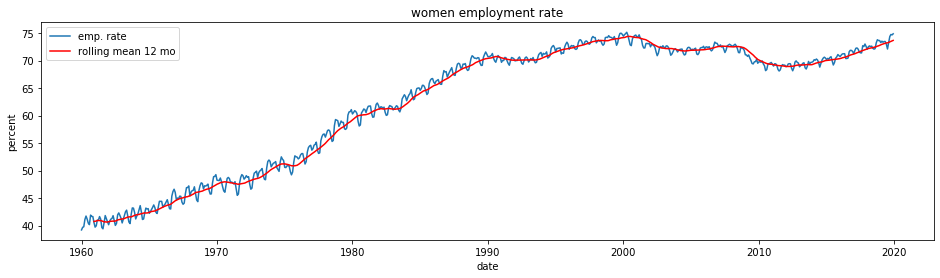

In [15]:
plt.figure(figsize=(16,4))
plt.plot(WmnEmpRate,label='emp. rate')
plt.plot(WmnEmpRate.rolling(12).mean(), 'r',label='rolling mean 12 mo' )
plt.xlabel('date')
plt.ylabel('percent')
plt.title('women employment rate')
plt.legend()


There is clearly a trand in the mean, but the variance seems to be stable. There are many ways to remove the trend in the data.
For time series for which the waveform morphology is important, it's better to use a technique with minimal distorsion to the waveform; for example, a zero distortion high pass FIR filtering. Other methods such as differencing are as effective for many
applications.


# Forecasting: Regression
In linear regression, the time evolution of the target variable is assumed to be linearly dependent on 
"exogenous" explanatory variables $x_{i,t}$.

- in general good when the trend is global
- polynomial trend can be added to the model
- seasonality can be taken into account using dummy variables
- fourier modes can be added
- avoid perfect collinearity between explanatory variables

$$y_t = \beta_0 + \sum\beta_i x_{i,t} + \epsilon_t$$
$$\epsilon_t \sim \mathcal{N}(0,\sigma^2)$$

## Additional features

In this example, since the trand seems to have both local and global, polynomial terms of appropriate order
should be considered.

### Polynomial Trends

In [16]:
DfLR = WmnEmpRate.copy()
DfLR['period']=DfLR.index.to_period(freq='M')
DfLR['t1'] = DfLR.period-DfLR.period.iloc[0]
DfLR['t1'] = DfLR['t1'].apply(lambda x: x.n)
DfLR.drop('period', axis=1, inplace=True)

In [17]:
DfLR.head()

,rate,t1
date,,
1960-01-01,39.198784,0
1960-02-01,39.678691,1
1960-03-01,39.762906,2
1960-04-01,41.099889,3
1960-05-01,41.719922,4


In [18]:
DfLR['t2'] =DfLR['t1']**2
DfLR['t3'] =DfLR['t1']**3

In [19]:
DfLR.head()

,rate,t1,t2,t3
date,,,,
1960-01-01,39.198784,0,0,0
1960-02-01,39.678691,1,1,1
1960-03-01,39.762906,2,4,8
1960-04-01,41.099889,3,9,27
1960-05-01,41.719922,4,16,64


## Train-Test Split

In [20]:
TrainPcnt = 0.75
FcstH = 24
X_train, y_train, X_test, y_test= TrainTestSplit(DfLR, 'rate', TrainPcnt, FcstH)
print("Train len: {0:d}, Test len: {1:d}".format(len(X_train), len(X_test)))

Train len: 540, Test len: 24


## Linear Regression

In [21]:
LRMdl = LinearRegression(normalize=True)
LRMdlFit = LRMdl.fit(X_train, y_train)

In [22]:
yh_train = LRMdlFit.predict(X_train)
yh_train_LR = pd.Series(data = yh_train, index=y_train.index)

yh_test = LRMdlFit.predict(X_test)
yh_test_LR = pd.Series(data = yh_test, index=y_test.index)

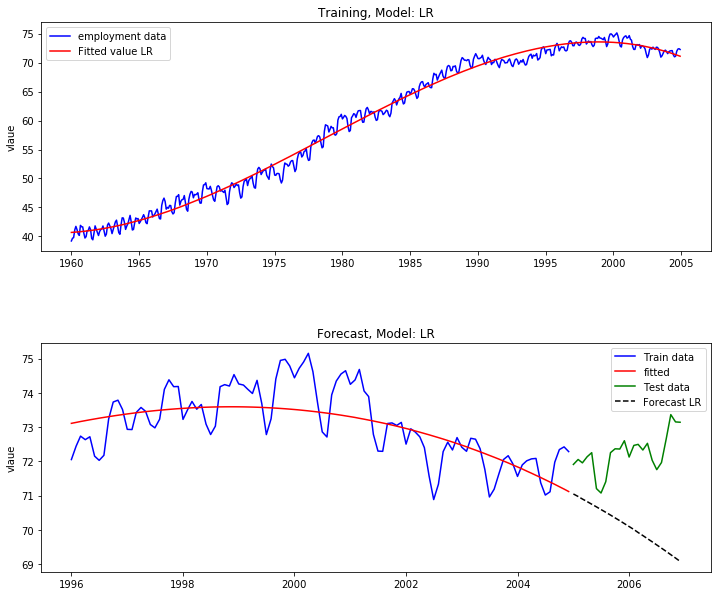

In [23]:
PlotForecast(y_train, y_test, yh_train_LR, yh_test_LR, ModelName='LR')

MAE=0.9014 RMSE=1.1270 MAPE=1.5872 MASE=1.7300


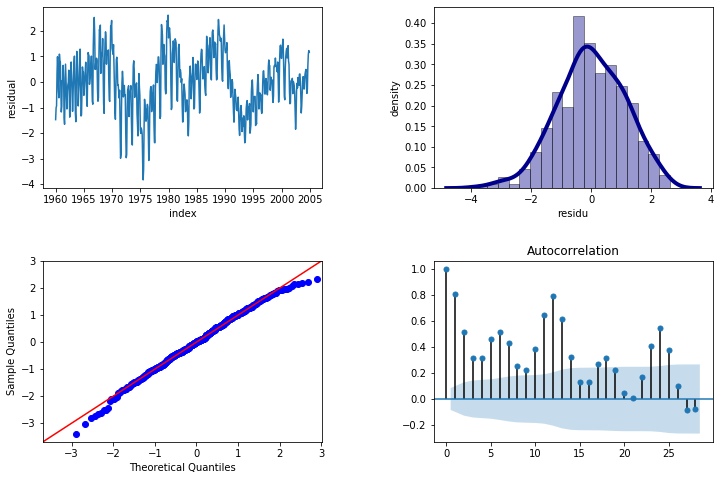

In [24]:
MAE_LR_Train, RMSE_LR_Train, MAPE_LR_Train, MASE_LR_Train, ResDf_LR_Train = Performance(y_train,yh_train_LR, bPlot=True)

MAE=2.1186 RMSE=2.3538 MAPE=2.9235 MASE=6.3968


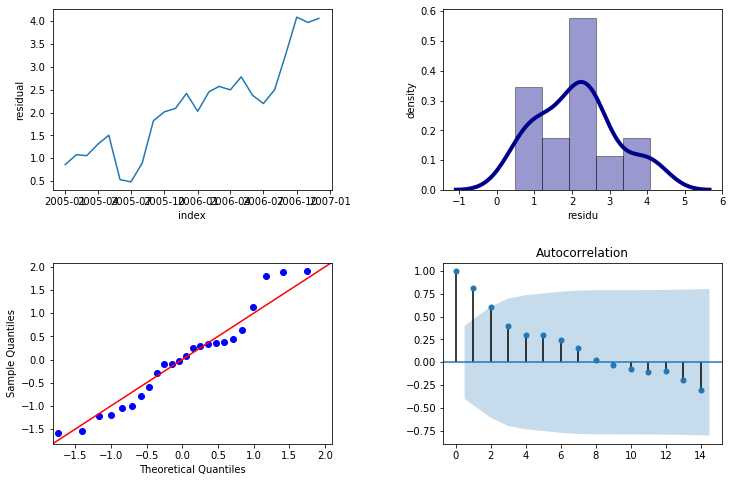

In [25]:
MAE_LR_Test, RMSE_LR_Test, MAPE_LR_Test, MASE_LR_Test, ResDf_LR_Test = Performance(y_test,yh_test_LR, bPlot=True)

## Seasonal Linear Regression

Seasonality is taken into account via dummifying months; this adds 11 additional features
to the model. This method may not be very efficient sepcially in cases where period is long and data 
are sampled at fine time intervals; for example, seasonal period of a year and data collected daily.

In [26]:
DfLRS = DfLR.copy()
DfLRS['month'] = WmnEmpRate.index.month

In [27]:
DfLRS.head()

,rate,t1,t2,t3,month
date,,,,,
1960-01-01,39.198784,0,0,0,1
1960-02-01,39.678691,1,1,1,2
1960-03-01,39.762906,2,4,8,3
1960-04-01,41.099889,3,9,27,4
1960-05-01,41.719922,4,16,64,5


In [28]:
DumDf= pd.get_dummies(DfLRS.month,drop_first=True,prefix='m')
DumDf.head()

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,
1960-01-01,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,0,0,0,1,0,0,0,0,0,0,0


In [29]:
DfLRSDum = pd.concat([DfLRS.drop('month', axis=1),DumDf], axis=1)

In [30]:
DfLRSDum.head()

,rate,t1,t2,t3,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,,,,,
1960-01-01,39.198784,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,39.678691,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,39.762906,2,4,8,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,41.099889,3,9,27,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,41.719922,4,16,64,0,0,0,1,0,0,0,0,0,0,0


In [34]:
TrainPcnt = 0.75
FcstH = 24
X_train_LRS, y_train_LRS, X_test_LRS, y_test_LRS= TrainTestSplit(DfLRSDum, 'rate', TrainPcnt, FcstH)
print("Train len: {0:d}, Test len: {1:d}".format(len(X_train_LRS), len(X_test_LRS)))

Train len: 540, Test len: 24


In [35]:
LRSMdl = LinearRegression(normalize=True)
LRSMdlFit = LRSMdl.fit(X_train_LRS,y_train_LRS)

In [36]:
yh_train = LRSMdlFit.predict(X_train_LRS)
yh_train_LRS = pd.Series(data = yh_train, index=y_train.index)

yh_test = LRSMdlFit.predict(X_test_LRS)
yh_test_LRS = pd.Series(data = yh_test, index=y_test.index)

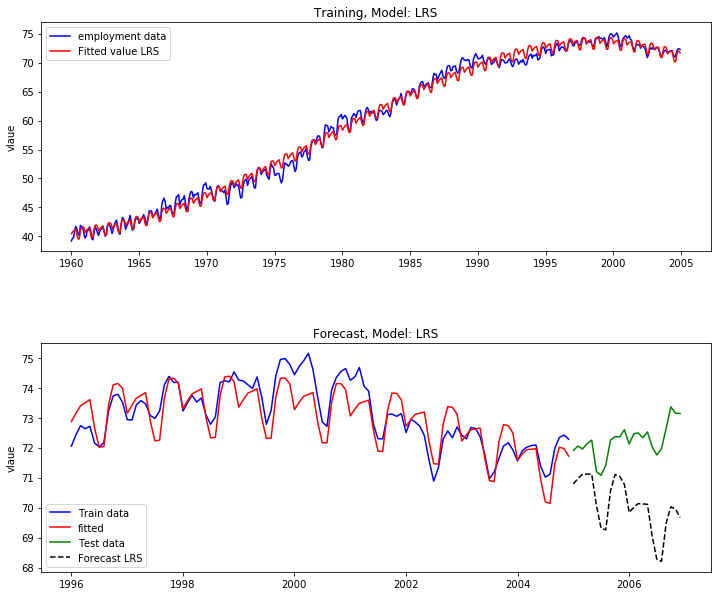

In [37]:
PlotForecast(y_train_LRS, y_test_LRS, yh_train_LRS, yh_test_LRS, ModelName='LRS')

MAE=0.7431 RMSE=0.9039 MAPE=1.2880 MASE=2.9430


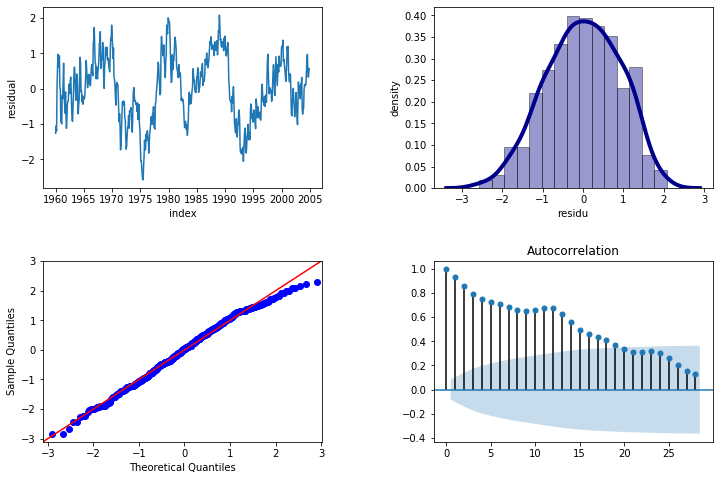

In [41]:
MAE_LRS_Train, RMSE_LRS_Train, MAPE_LRS_Train, MASE_LRS_Train, ResDf_LRS_Train = Performance(y_train_LRS,yh_train_LRS, bPlot=True)

MAE=2.1447 RMSE=2.3292 MAPE=2.9653 MASE=7.4272


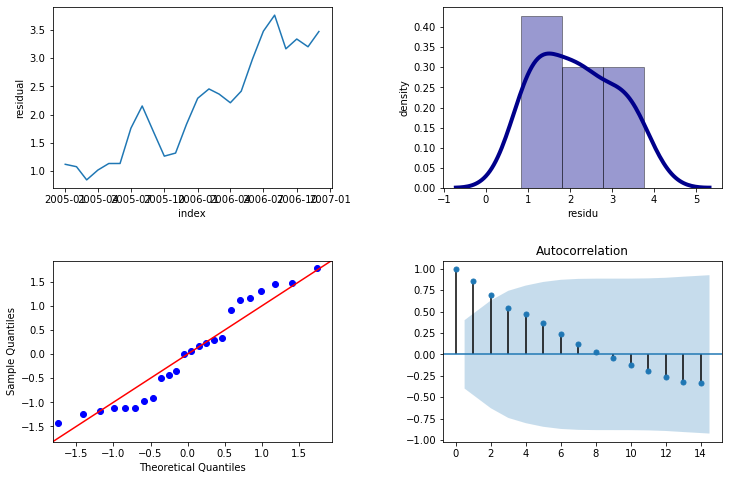

In [40]:
MAE_LRS_Test, RMSE_LRS_Test, MAPE_LRS_Test, MASE_LRS_Test, ResDf_LRS_Test = Performance(y_test_LRS,yh_test_LRS, bPlot=True)

## Fourier modes/features
Another approach to complex seasonality is to include Fourier modes
$$sin(k\omega t), \text{and}\, cos(k\omega t),\;\; k=1,2,\ldots$$

They impose global strutures to the models. If seasonality has a local nature, more Fourier modes are
required. The types and number of features should be selected systematically using performance metrics such as AIC, BIC etc 
where the model complexity is also taken into account.

In [42]:
DfSF = DfLR.copy()

In [43]:
DfSF.head()

,rate,t1,t2,t3
date,,,,
1960-01-01,39.198784,0,0,0
1960-02-01,39.678691,1,1,1
1960-03-01,39.762906,2,4,8
1960-04-01,41.099889,3,9,27
1960-05-01,41.719922,4,16,64


In [44]:
DfSF['S1'] = DfSF.t1.apply(lambda x: np.sin(2*np.pi*x/12))
DfSF['C1'] = DfSF.t1.apply(lambda x: np.cos(2*np.pi*x/12))

DfSF['S2'] = DfSF.t1.apply(lambda x: np.sin(4*np.pi*x/12))
DfSF['C2'] = DfSF.t1.apply(lambda x: np.cos(4*np.pi*x/12))

DfSF['S4'] = DfSF.t1.apply(lambda x: np.sin(6*np.pi*x/12))
DfSF['C6'] = DfSF.t1.apply(lambda x: np.cos(6*np.pi*x/12))

In [45]:
DfSF.head()

,rate,t1,t2,t3,S1,C1,S2,C2,S4,C6
date,,,,,,,,,,
1960-01-01,39.198784,0,0,0,0.000000,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
1960-02-01,39.678691,1,1,1,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17
1960-03-01,39.762906,2,4,8,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00
1960-04-01,41.099889,3,9,27,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16
1960-05-01,41.719922,4,16,64,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00


In [46]:
TrainPcnt = 0.75
FcstH = 24
X_train_LRF, y_train_LRF, X_test_LRF, y_test_LRF= TrainTestSplit(DfSF, 'rate', TrainPcnt, FcstH)
print("Train len: {0:d}, Test len: {1:d}".format(len(X_train_LRF), len(X_test_LRF)))

Train len: 540, Test len: 24


In [47]:
LRFMdl = LinearRegression(normalize=True)
LRFMdlFit = LRFMdl.fit(X_train_LRF, y_train_LRF)

In [48]:
yh_train = LRFMdlFit.predict(X_train_LRF)
yh_train_LRF = pd.Series(data = yh_train, index=y_train.index)

yh_test = LRFMdlFit.predict(X_test_LRF)
yh_test_LRF = pd.Series(data = yh_test, index=y_test.index)

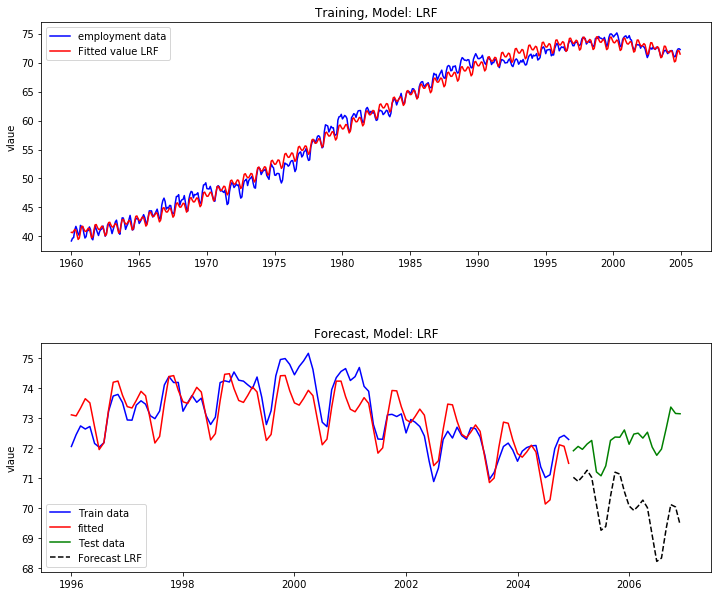

In [49]:
PlotForecast(y_train_LRF, y_test_LRF, yh_train_LRF, yh_test_LRF, ModelName='LRF')

MAE=0.7471 RMSE=0.9138 MAPE=1.2949 MASE=2.3432


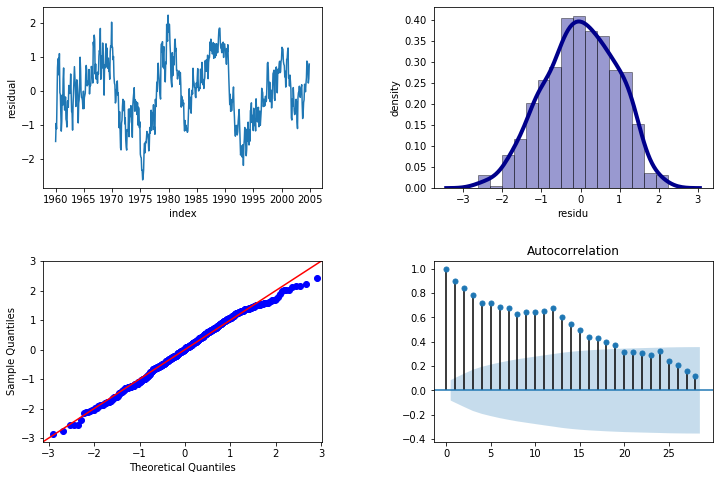

In [50]:
MAE_LRF_Train, RMSE_LRF_Train, MAPE_LRF_Train, MASE_LRF_Train, ResDf_LRF_Train = Performance(y_train_LRF,yh_train_LRF, bPlot=True)

MAE=2.1386 RMSE=2.3318 MAPE=2.9564 MASE=6.6737


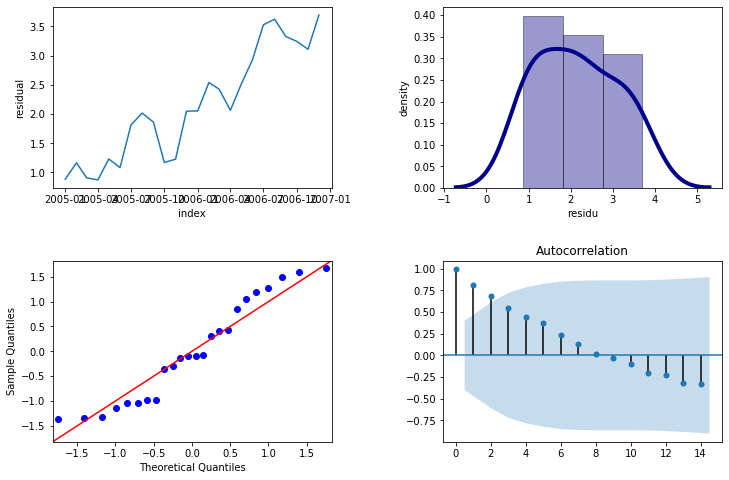

In [51]:
MAE_LRF_Test, RMSE_LRF_Test, MAPE_LRF_Test, MASE_LRF_Test, ResDf_LRF_Test = Performance(y_test_LRF,yh_test_LRF, bPlot=True)

## Conclusion
Regression models are:

- simple
- interpretable
- powerful

To do inference or computing confidence/prediction intervals the assumption that residual is WN
must hold. This assumption can be checked by looking at residu dignostics:

- Residue must be normally distributed
- the ACF must not have significant lags
- use e.g., Ljung-Box test to acertain $Res \sim WN$

In dynamic regression this assumption is relaxed. It is assumed that the model error is an ARIMA process.

In [59]:
DfLRPerf = pd.DataFrame(data=np.array([[MAE_LR_Train, RMSE_LR_Train, MAPE_LR_Train, MASE_LR_Train],
                                       [MAE_LR_Test, RMSE_LR_Test, MAPE_LR_Test, MASE_LR_Test]]), index=['train_LR', 'test_LR'],
                       columns=['MAE', 'RMSE', 'MAPE','MASE'])
DfLRSPerf = pd.DataFrame(data=np.array([[MAE_LRS_Train, RMSE_LRS_Train, MAPE_LRS_Train, MASE_LRS_Train],
                                       [MAE_LRS_Test, RMSE_LRS_Test, MAPE_LRS_Test, MASE_LRS_Test]]), index=['train_LRS', 'test_LRS'],
                       columns=['MAE', 'RMSE', 'MAPE','MASE'])
DfLRFPerf = pd.DataFrame(data=np.array([[MAE_LRF_Train, RMSE_LRF_Train, MAPE_LRF_Train, MASE_LRF_Train],
                                       [MAE_LRF_Test, RMSE_LRF_Test, MAPE_LRF_Test, MASE_LRF_Test]]), index=['train_LRF', 'test_LRF'],
                       columns=['MAE', 'RMSE', 'MAPE','MASE'])

In [60]:
DfPerf = pd.concat([DfLRPerf, DfLRSPerf, DfLRFPerf])

In [61]:
DfPerf

,MAE,RMSE,MAPE,MASE
train_LR,0.901431,1.127006,1.587158,1.730042
test_LR,2.118568,2.353821,2.923506,6.396818
train_LRS,0.743129,0.903932,1.287999,2.942960
test_LRS,2.144715,2.329168,2.965287,7.427190
train_LRF,0.747121,0.913763,1.294937,2.343190
test_LRF,2.138554,2.331755,2.956435,6.673704


In all cases, the ACF plot shows that the residual is not a white noise process. the Ljung-Box test confirms it;
remember:
- $H_0$: data is WN
- $H_a$ data has serial correlation

In [63]:
ljb, pVal = sm.stats.acorr_ljungbox(ResDf_LR_Train, lags=[24])
print("ljb = %f,  p-val = %f" %(ljb,pVal))

ljb = 2375.863173,  p-val = 0.000000


c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


p-value is very small => reject H0 => residual is not WN

In [64]:
ljb, pVal = sm.stats.acorr_ljungbox(ResDf_LRS_Train, lags=[24])
print("ljb = %f,  p-val = %f" %(ljb,pVal))

ljb = 4762.024305,  p-val = 0.000000


In [65]:
ljb, pVal = sm.stats.acorr_ljungbox(ResDf_LRF_Train, lags=[24])
print("ljb = %f,  p-val = %f" %(ljb,pVal))

ljb = 4556.978632,  p-val = 0.000000


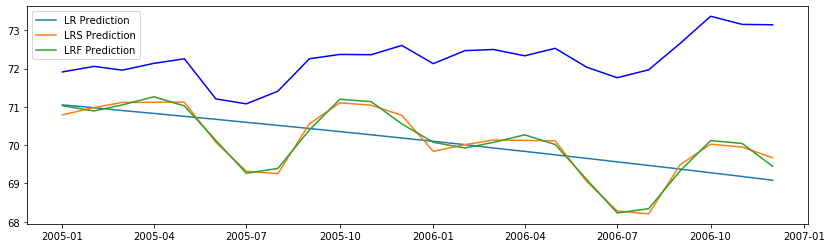

In [67]:
plt.figure(figsize=(14,4))
plt.plot(y_test,'b')
plt.plot(yh_test_LR, label='LR Prediction')
plt.plot(yh_test_LRS, label='LRS Prediction')
plt.plot(yh_test_LRF, label='LRF Prediction')
plt.legend()